<a href="https://colab.research.google.com/github/matheusro/Uniritter-topicos2-NLP/blob/master/Trabalho_Topicos_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Prático - Processamento de Linguagem Natural
Disciplina: Tópicos II / Professor: William Becker

### Alunos:
Gustavo da Costa Oliveira / Vinícius Valim de Melo / Cláudia Duarte Rodrigues de Oliveira / Matheus Reck de Oliveira

Fonte do Dataset: https://www.kaggle.com/cursostic/avaliao-atendimento#all.csv

Os dados analisados contêm avaliações de atendimento de equipe de Suporte de TI.

In [40]:
import numpy as np
#np.random.seed(100)

import pandas as pd
dataset = pd.read_excel("all.xlsx")

In [41]:
print(dataset)

                                                  coment manifest_atendimento
0                              Nunca abri esse incidente               neutro
1      Profissionais educados, atenciosos e o mais im...               elogio
2      Não tenho condições de responder a esta pesqui...           reclamação
3      Chamado não foi resolvido. Apesar de explicado...           reclamação
4      O chamado foi encerrado como concluído. Porém,...           reclamação
...                                                  ...                  ...
42309  O problema não foi resolvido, porém foi fornec...               neutro
42310                            Excelente atendimento!!               elogio
42311                              Atendimento perfeito.               elogio
42312  Não foi resolvido por motivos externos, servid...               neutro
42313                   Serviço com atendimento perfeito               elogio

[42314 rows x 2 columns]


In [42]:
print(dataset.describe()) 

                        coment manifest_atendimento
count                    42306                42314
unique                   31253                    3
top     Excelente atendimento.               elogio
freq                       634                27630


In [43]:
# remove os comentarios nulos
dataset = dataset[dataset["coment"].isnull() == False]

In [44]:
print(dataset.describe()) 

                        coment manifest_atendimento
count                    42306                42306
unique                   31253                    3
top     Excelente atendimento.               elogio
freq                       634                27630


In [45]:
print(dataset['manifest_atendimento'].value_counts())

elogio        27630
neutro         8174
reclamação     6502
Name: manifest_atendimento, dtype: int64


In [46]:
print(dataset.dtypes)

coment                  object
manifest_atendimento    object
dtype: object


In [47]:
# converte os comentarios para string
dataset['coment'] = dataset.coment.astype(str)
# converte os manifestos para categorico
dataset['manifest_atendimento'] = dataset.manifest_atendimento.astype('category')

In [48]:
import nltk
# importa tokenizadores e stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\claudia_roliveira\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\claudia_roliveira\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:
# preparacao dos dados
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# tokenizando as sentencas
dataset["coment"] = [word_tokenize(word) for word in dataset["coment"]]
print(dataset)

                                                  coment manifest_atendimento
0                         [Nunca, abri, esse, incidente]               neutro
1      [Profissionais, educados, ,, atenciosos, e, o,...               elogio
2      [Não, tenho, condições, de, responder, a, esta...           reclamação
3      [Chamado, não, foi, resolvido, ., Apesar, de, ...           reclamação
4      [O, chamado, foi, encerrado, como, concluído, ...           reclamação
...                                                  ...                  ...
42309  [O, problema, não, foi, resolvido, ,, porém, f...               neutro
42310                     [Excelente, atendimento, !, !]               elogio
42311                         [Atendimento, perfeito, .]               elogio
42312  [Não, foi, resolvido, por, motivos, externos, ...               neutro
42313              [Serviço, com, atendimento, perfeito]               elogio

[42306 rows x 2 columns]


In [50]:
# remocao de stopwords
dataset["coment"] = dataset["coment"].apply(lambda x: [item for item in x if item not in stopwords.words("portuguese")])

In [52]:
print(dataset.head())

                                              coment manifest_atendimento
0                           [Nunca, abri, incidente]               neutro
1  [Profissionais, educados, ,, atenciosos, impor...               elogio
2  [Não, condições, responder, pesquisa, ., Onde,...           reclamação
3  [Chamado, resolvido, ., Apesar, explicado, nec...           reclamação
4  [O, chamado, encerrado, concluído, ., Porém, ,...           reclamação


In [53]:
# considera todas avaliações neutras como reclamação para equilibrar a amostragem entre 'elogio' X 'reclamação'
manifest_atendimento = {'neutro':'reclamação'}
dataset = dataset.replace(manifest_atendimento)

In [54]:
print(dataset['manifest_atendimento'].value_counts())

elogio        27630
reclamação    14676
Name: manifest_atendimento, dtype: int64


In [55]:
dataset["coment"] = [' '.join(word) for word in dataset["coment"]]
print(dataset.head())

                                              coment manifest_atendimento
0                               Nunca abri incidente           reclamação
1  Profissionais educados , atenciosos importante...               elogio
2  Não condições responder pesquisa . Onde parece...           reclamação
3  Chamado resolvido . Apesar explicado necessida...           reclamação
4  O chamado encerrado concluído . Porém , ramal ...           reclamação


In [56]:
import unicodedata
import re

In [57]:
def removerAcentosECaracteresEspeciais(palavra):

    # Unicode normalize transforma um caracter em seu equivalente em latin.
    nfkd = unicodedata.normalize('NFKD', palavra)
    palavraSemAcento = u"".join([c for c in nfkd if not unicodedata.combining(c)])

    # Usa expressão regular para retornar a palavra apenas com números, letras e espaço
    return re.sub('[^a-zA-Z0-9 \\\]', '', palavraSemAcento)

In [61]:
# realiza a limpeza nos dados (lowecase e remocao de caracteres)
remove_caracteres = re.compile('[^0-9a-z #+_]')
replace_espaco = re.compile('[/(){}\[\]\|@,;]')

def pre_processamento(text):
    text = text.lower()
    #text = remove_caracteres.sub('', text)
    text = replace_espaco.sub(' ', text)
    return text

dataset['coment'] = dataset['coment'].apply(pre_processamento)
dataset['coment'] = dataset['coment'].apply(removerAcentosECaracteresEspeciais)

In [62]:
print(dataset.head())

                                              coment manifest_atendimento
0                               nunca abri incidente           reclamação
1  profissionais educados   atenciosos importante...               elogio
2  nao condicoes responder pesquisa  onde parecer...           reclamação
3  chamado resolvido  apesar explicado necessidad...           reclamação
4  o chamado encerrado concluido  porem   ramal c...           reclamação


In [63]:
# GERAR MAIS ANÁLISES - EX.: PALAVRAS MAIS FREQUENTES.

In [23]:
pip install wordcloud

from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

Note: you may need to restart the kernel to use updated packages.


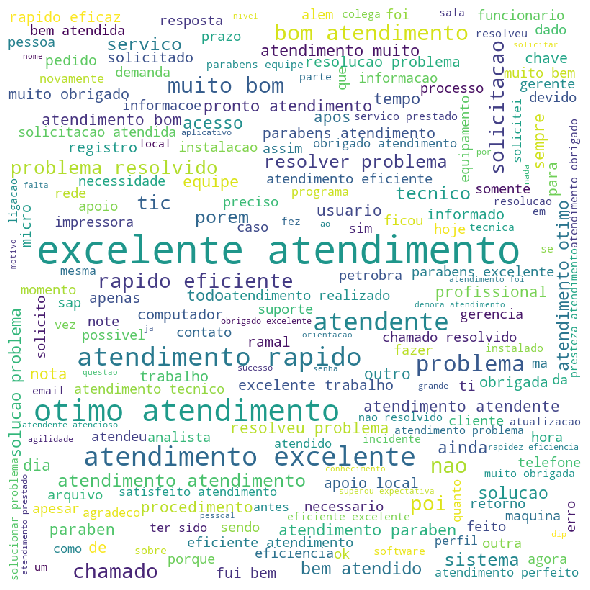

In [64]:
comment_words = ''  
stopwords = set(STOPWORDS)
for val in dataset.coment: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
       # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [31]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset["coment"], 
                                                                    dataset["manifest_atendimento"], 
                                                                    test_size=0.3)

In [32]:
from sklearn.preprocessing import LabelEncoder

Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(dataset["coment"])
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

In [111]:
Tfidf_vect.vocabulary_

{'nunca': 3170,
 'abri': 109,
 'incidente': 2466,
 'profissionais': 3729,
 'educados': 1634,
 'atenciosos': 470,
 'importante': 2434,
 'problema': 3704,
 'resolvido': 4118,
 'envolvidos': 1805,
 'parabns': 3331,
 'obrigado': 3182,
 'no': 3129,
 'condies': 983,
 'responder': 4128,
 'pesquisa': 3483,
 'onde': 3239,
 'parecer': 3341,
 'prometido': 3745,
 'rea': 3876,
 'tcnica': 4569,
 'explicando': 2013,
 'soluo': 4471,
 'dada': 1234,
 'momento': 2999,
 'apenas': 384,
 'provisria': 3771,
 'com': 895,
 'elementos': 1669,
 'aqui': 428,
 'apresentados': 408,
 'avaliao': 592,
 'pode': 3526,
 'ser': 4346,
 'negativa': 3101,
 'chamado': 808,
 'apesar': 385,
 'explicado': 2011,
 'necessidade': 3087,
 'privilgios': 3696,
 'administrador': 198,
 'notebook': 3152,
 'deve': 1464,
 'fato': 2074,
 'gerncia': 2283,
 'presta': 3651,
 'suporte': 4535,
 'automao': 575,
 'atendente': 477,
 'encerrado': 1726,
 'concludo': 974,
 'porm': 3551,
 'ramal': 3849,
 'continua': 1106,
 'constando': 1067,
 'conta': 1

In [34]:
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score

Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf, y_train)

predictions = Naive.predict(Test_X_Tfidf)

In [35]:
print("Acuracia NB:", accuracy_score(predictions, y_test)*100)

Acuracia NB: 92.85376615190671


In [0]:
# INCLUIR UM TESTE DO MODELO 
## Inventar um ELOGIO e um RECLAMAÇÃO